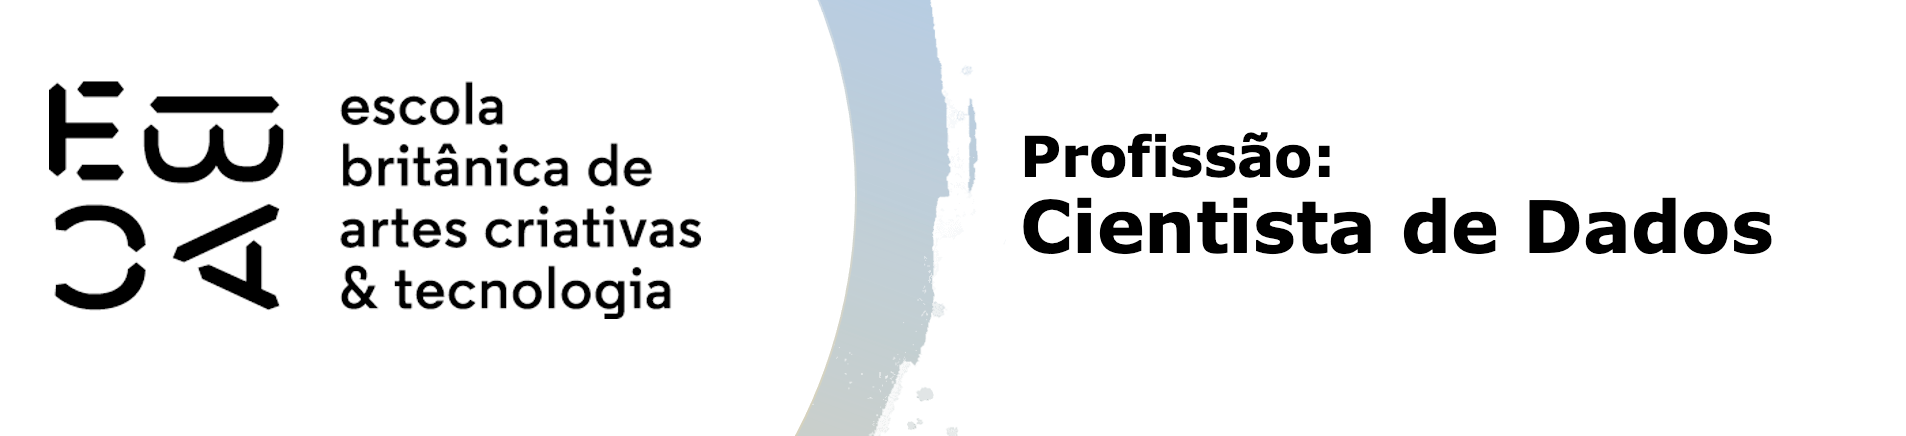

# Rodrigo Schulz

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

In [53]:
import pandas as pd

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [54]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [55]:
dataset = df.sample(50000)

In [56]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

## Descritiva básica univariada

In [57]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


## Descritiva bivariada

In [58]:
from pycaret.classification import *

In [59]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [60]:
# Definir tipos de dados
categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
numeric_vars = ['index', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Gerar metadados
metadata = []
for column in df.columns:
    if column in categorical_vars:
        var_type = 'Categórica'
    elif column in numeric_vars:
        var_type = 'Numérica'
    else:
        var_type = 'Desconhecida'
    metadata.append((column, var_type))

# Exibir metadados
for column, var_type in metadata:
    print(f'{column}: {var_type}')

data_ref: Desconhecida
index: Numérica
sexo: Categórica
posse_de_veiculo: Categórica
posse_de_imovel: Categórica
qtd_filhos: Numérica
tipo_renda: Categórica
educacao: Categórica
estado_civil: Categórica
tipo_residencia: Categórica
idade: Numérica
tempo_emprego: Numérica
qt_pessoas_residencia: Numérica
renda: Numérica
mau: Categórica


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [61]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [62]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [63]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [64]:
data.corr()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
qtd_filhos,1.000000,-0.367034,-0.072152,0.891134,-0.038619,-0.002877
idade,-0.367034,1.000000,0.339161,-0.338816,0.102771,-0.023410
tempo_emprego,-0.072152,0.339161,1.000000,-0.067877,0.485030,-0.125229
qt_pessoas_residencia,0.891134,-0.338816,-0.067877,1.000000,-0.051124,-0.004168
renda,-0.038619,0.102771,0.485030,-0.051124,1.000000,-0.063672
mau,-0.002877,-0.023410,-0.125229,-0.004168,-0.063672,1.000000


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

In [65]:
data.mau.value_counts(normalize=True)

False    0.924821
True     0.075179
Name: mau, dtype: float64

In [66]:
data.isna().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            8094
qt_pessoas_residencia       0
renda                       0
mau                         0
dtype: int64

In [67]:
# Substituir valores nulos pela média em "tempo_emprego"
mean_tempo_emprego = df['tempo_emprego'].mean()
df['tempo_emprego'].fillna(mean_tempo_emprego, inplace=True)

In [68]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)

,Description,Value
0,Session id,7196
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(75750, 30)"
5,Transformed train set shape,"(61500, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


### Remoção de outliers

In [69]:
df = pd.DataFrame(data)

# Identificar outliers usando Z-Score
z_scores = stats.zscore(df['idade'])
threshold = 3  # Limite para considerar um valor como outlier
outliers_z = df[abs(z_scores) > threshold]

print("Outliers usando Z-Score:")
print(outliers_z)

# Identificar outliers usando IQR
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[(df['renda'] < lower_bound) | (df['renda'] > upper_bound)]

print("\nOutliers usando IQR:")
print(outliers_iqr)

Outliers usando Z-Score:
Empty DataFrame
Columns: [sexo, posse_de_veiculo, posse_de_imovel, qtd_filhos, tipo_renda, educacao, estado_civil, tipo_residencia, idade, tempo_emprego, qt_pessoas_residencia, renda, mau]
Index: []

Outliers usando IQR:
      sexo posse_de_veiculo posse_de_imovel  qtd_filhos        tipo_renda  \
6        M                N               N         1.0        Empresário   
9        F                S               N         0.0       Assalariado   
31       M                N               S         1.0        Empresário   
57       F                S               S         0.0       Assalariado   
64       F                N               N         0.0       Assalariado   
...    ...              ...             ...         ...               ...   
47439    M                S               S         2.0        Empresário   
47448    F                N               N         0.0        Empresário   
47450    F                N               N         0.0      

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [36]:
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=5)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=200)

In [37]:
X_digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [38]:
X_digits.shape

(1797, 64)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [39]:
# "Fitando" e aplicando Z score nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [40]:
# "Fitando" e aplicando o pca nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

In [41]:
# "Fitando" e predizendo uma regressão logística nos dados de treino
logistic.fit(X_train, y_train)

logistic.predict(X_train)

array([0, 0, 0, ..., 2, 2, 2])

In [42]:
# Aplicando nos dados de teste o Z score "fitado" nos dados de treino  
X_test = scaler.transform(X_test)

# Aplicando nos dados de teste o PCA "fitado" nos dados de treino  
X_test = pca.transform(X_test)

# Predizendo nos dados de teste o modelo "fitado" nos dados de treino
logistic.predict(X_test)

array([5, 2, 5, 4, 2, 1, 4, 3, 3, 0, 8, 2, 0, 1, 8, 6, 7, 7, 9, 8, 6, 6,
       6, 7, 8, 5, 5, 7, 9, 9, 9, 3, 7, 3, 4, 1, 3, 2, 5, 4, 2, 1, 0, 3,
       3, 3, 6, 1, 9, 4, 4, 2, 8, 4, 1, 5, 7, 7, 1, 0, 4, 5, 7, 4, 7, 9,
       0, 7, 8, 3, 9, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 7,
       8, 8, 2, 6, 3, 4, 7, 3, 8, 1, 9, 2, 5, 0, 9, 0, 4, 5, 5, 0, 6, 7,
       3, 3, 7, 1, 7, 4, 6, 0, 5, 8, 1, 2, 7, 9, 9, 5, 2, 3, 3, 8, 7, 6,
       2, 5, 4, 9, 8, 7, 6, 7, 2, 7, 4, 9, 8, 1, 9, 8, 6, 1, 1, 1, 4, 0,
       5, 9, 7, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 5, 6, 7, 0,
       9, 9, 4, 7, 8, 9, 2, 0, 6, 7, 5, 3, 7, 7, 1, 3, 2, 9, 7, 3, 1, 7,
       2, 1, 8, 7, 1, 6, 4, 6, 9, 5, 2, 3, 5, 3, 9, 8, 4, 8, 2, 5, 9, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 1, 0, 6, 9,
       4, 4, 7, 7, 5, 6, 2, 8, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 3, 7, 2, 0, 2, 0, 9, 2, 8, 6, 2, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 8, 0, 8, 4, 7, 9, 3,

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=15)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic_pipe = LogisticRegression(max_iter=200)

In [44]:
pipe = Pipeline(steps=[("scaler", scaler_pipe), 
                       ("pca", pca_pipe), 
                       ("logistic", logistic_pipe)])

In [45]:
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [11]:
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9211,0.7780,0.0472,0.5147,0.0861,0.0736,0.1366,0.4400
lr,Logistic Regression,0.9210,0.7703,0.0000,0.0000,0.0000,0.0000,0.0000,0.6680
ridge,Ridge Classifier,0.9210,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1250
lda,Linear Discriminant Analysis,0.9210,0.6476,0.0000,0.0000,0.0000,-0.0001,-0.0007,0.1520
dummy,Dummy Classifier,0.9210,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1150
gbc,Gradient Boosting Classifier,0.9207,0.7810,0.0350,0.4802,0.0651,0.0547,0.1121,1.0270
lightgbm,Light Gradient Boosting Machine,0.9203,0.7741,0.0365,0.4533,0.0674,0.0560,0.1099,0.3350
knn,K Neighbors Classifier,0.9140,0.6450,0.0811,0.3231,0.1293,0.1010,0.1285,0.3560
svm,SVM - Linear Kernel,0.9055,0.0000,0.1763,0.2353,0.1923,0.1565,0.1621,0.1520
rf,Random Forest Classifier,0.9010,0.7137,0.0990,0.2211,0.1365,0.0919,0.1005,0.8260


In [13]:
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=123)


In [14]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9212,0.7707,0.0191,0.5000,0.0368,0.0312,0.0859
1,0.9215,0.8106,0.0534,0.5185,0.0969,0.0834,0.1477
2,0.9212,0.7650,0.0344,0.5000,0.0643,0.0547,0.1153
3,0.9161,0.7691,0.0115,0.1304,0.0211,0.0084,0.0160
4,0.9227,0.7886,0.0494,0.6500,0.0919,0.0816,0.1646
5,0.9206,0.7745,0.0418,0.4783,0.0769,0.0650,0.1234
6,0.9188,0.7965,0.0304,0.3478,0.0559,0.0438,0.0831
7,0.9212,0.7844,0.0380,0.5263,0.0709,0.0609,0.1256
8,0.9218,0.7568,0.0380,0.5882,0.0714,0.0624,0.1352


In [15]:
tuned_gbc = tune_model(gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9041,0.6989,0.0916,0.2286,0.1308,0.0897,0.1004
1,0.9080,0.7538,0.1336,0.3070,0.1862,0.1453,0.1596
2,0.9083,0.7049,0.0878,0.2584,0.1311,0.0949,0.1106
3,0.9050,0.7106,0.1145,0.2632,0.1596,0.1174,0.1289
4,0.9023,0.7261,0.1103,0.2417,0.1514,0.1072,0.1166
5,0.8989,0.7139,0.1103,0.2214,0.1472,0.0999,0.1068
6,0.9113,0.7449,0.1179,0.3298,0.1737,0.1378,0.1584
7,0.9101,0.7503,0.1065,0.3043,0.1577,0.1217,0.1408
8,0.9050,0.6982,0.1103,0.2613,0.1551,0.1135,0.1254


Fitting 10 folds for each of 10 candidates, totalling 100 fits


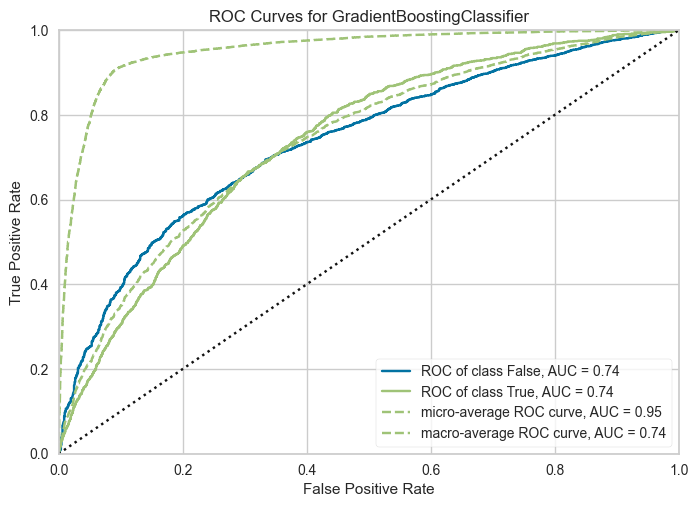

In [16]:
plot_model(tuned_gbc, plot = 'auc')

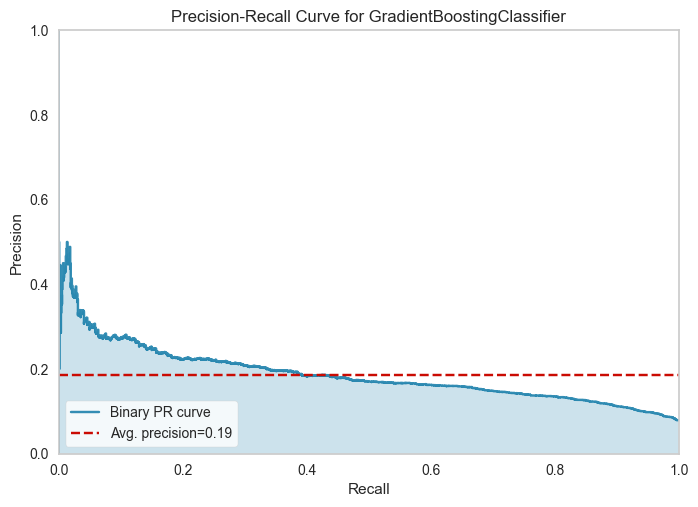

In [17]:
plot_model(tuned_gbc, plot = 'pr')

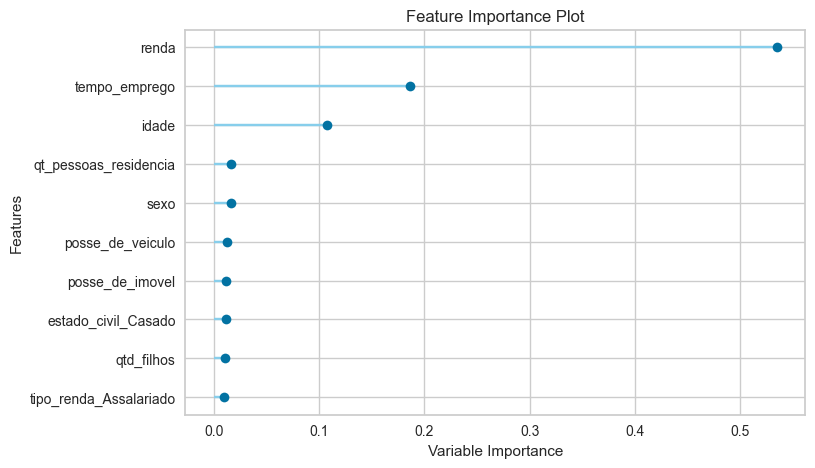

In [18]:
plot_model(tuned_gbc, plot='feature')

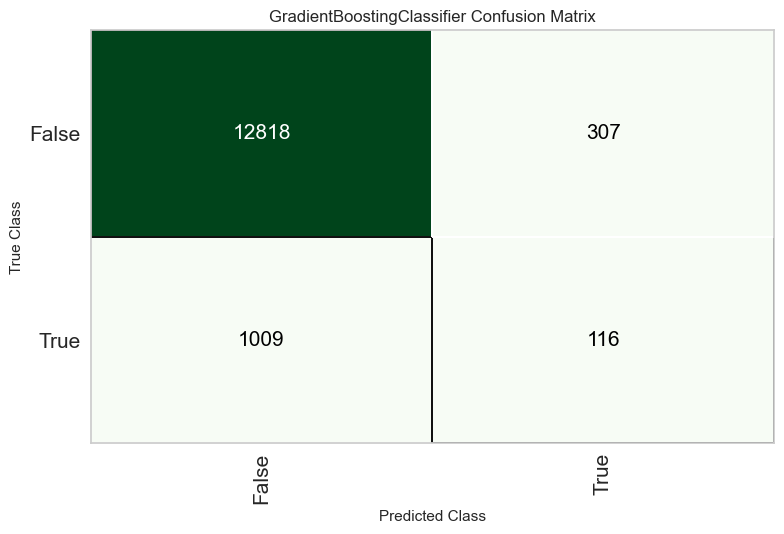

In [19]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [20]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [21]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9076,0.7375,0.1031,0.2742,0.1499,0.1115,0.1267


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
5866,F,N,S,1.0,Assalariado,Médio,União,Casa,41,18.553425,3.0,53097.179688,False,0,0.9922
23161,F,S,N,0.0,Assalariado,Superior completo,Casado,Casa,41,15.041096,2.0,9437.330078,False,0,0.9603
28839,M,N,S,1.0,Assalariado,Médio,Casado,Casa,44,4.594521,3.0,1671.089966,True,0,0.8452
40589,F,N,S,0.0,Pensionista,Fundamental,Casado,Casa,68,NaN,2.0,2674.280029,False,0,0.7007
26648,F,N,N,0.0,Assalariado,Médio,Casado,Casa,47,8.967123,2.0,30180.619141,False,0,0.9906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473,F,N,N,0.0,Empresário,Médio,Casado,Casa,65,16.621918,2.0,36403.300781,False,0,0.9892
7866,F,S,N,0.0,Empresário,Médio,União,Com os pais,44,2.849315,2.0,8413.589844,False,0,0.9765
8020,M,N,N,0.0,Assalariado,Superior completo,Solteiro,Com os pais,31,1.967123,1.0,2568.939941,False,0,0.8593
32742,M,S,N,0.0,Empresário,Médio,Casado,Casa,49,14.273973,2.0,55167.750000,False,0,0.9941


In [22]:
final_gbc = finalize_model(tuned_gbc)

In [23]:
#Parâmetros finais do modelo Random Forest para deploy
print(final_gbc)

Pipeline(memory=FastMemory(location=C:\Users\rodri\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',...
                                            criterion='friedman_mse', init=None,
                                            learning_r

In [25]:
predict_model(final_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9336,0.8529,0.2382,0.7507,0.3617,0.3364,0.3993


In [26]:
unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9060,0.7235,0.0761,0.1772,0.1065,0.0651,0.0717


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Empresário,Médio,Solteiro,Casa,36,5.378082,1.0,3780.419922,False,0,0.9527
1,M,S,N,2,Empresário,Médio,Casado,Casa,40,10.547945,4.0,10093.809570,False,0,0.9726
2,M,S,S,2,Assalariado,Médio,Casado,Casa,24,2.789041,4.0,1341.239990,True,0,0.6890
3,F,N,N,0,Assalariado,Médio,Casado,Casa,46,15.087671,2.0,6670.390137,False,0,0.9544
4,F,S,S,0,Assalariado,Médio,Casado,Casa,59,15.520548,2.0,72139.718750,False,0,0.9932


In [27]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

In [30]:
save_model(final_gbc,'Final GBC Model 29Ago2023')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\rodri\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',...
                                             criterion='friedman_mse', init=None,
                                         